Current date/time: 2025-04-20 15:55:04.576855
===== Buy Low / Sell High Strategy System =====

Fetching data for AAPL...
Fetched 502 data points for AAPL
Fetching benchmark data for SPY...
Fetching data for SPY...
Adding technical indicators...
Starting enhanced parameter optimization...

Enhanced Best Parameters: RSI=35, ATR Stop=2.0, ATR Take=5.0, Score=1.40
Parameter optimization results available but visualization disabled.
Best parameters from optimization process (Note: optimization Sharpe differs from final backtest): RSI=35.0, ATR Stop=2.0, ATR Take=5.0, Optimization Sharpe=1.42

Using parameters for final backtest: RSI=35, ATR Stop=2.0, ATR Take=5.0
Note: Final performance metrics may differ from optimization due to different calculation methods.

=== Running Final Backtest with Optimal Parameters ===
Backtesting strategy...

Backtest Summary: 222 trades completed with 55.41% win rate

=== Detailed Trade Analysis ===
Total Trades: 222
Win Rate: 55.41%  (Wins=123, Losses=99)
Av

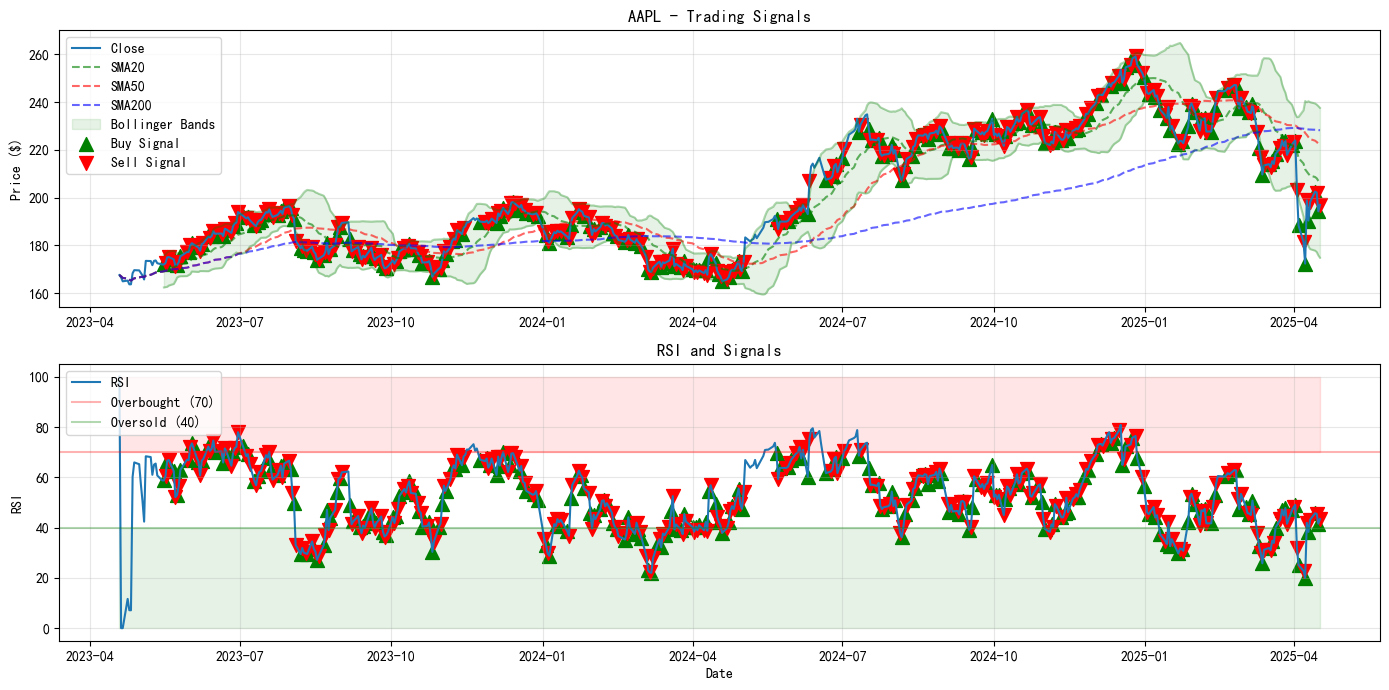

Chart 1 generated (Price & RSI with signals) and saved to AAPL_trading_signals.png


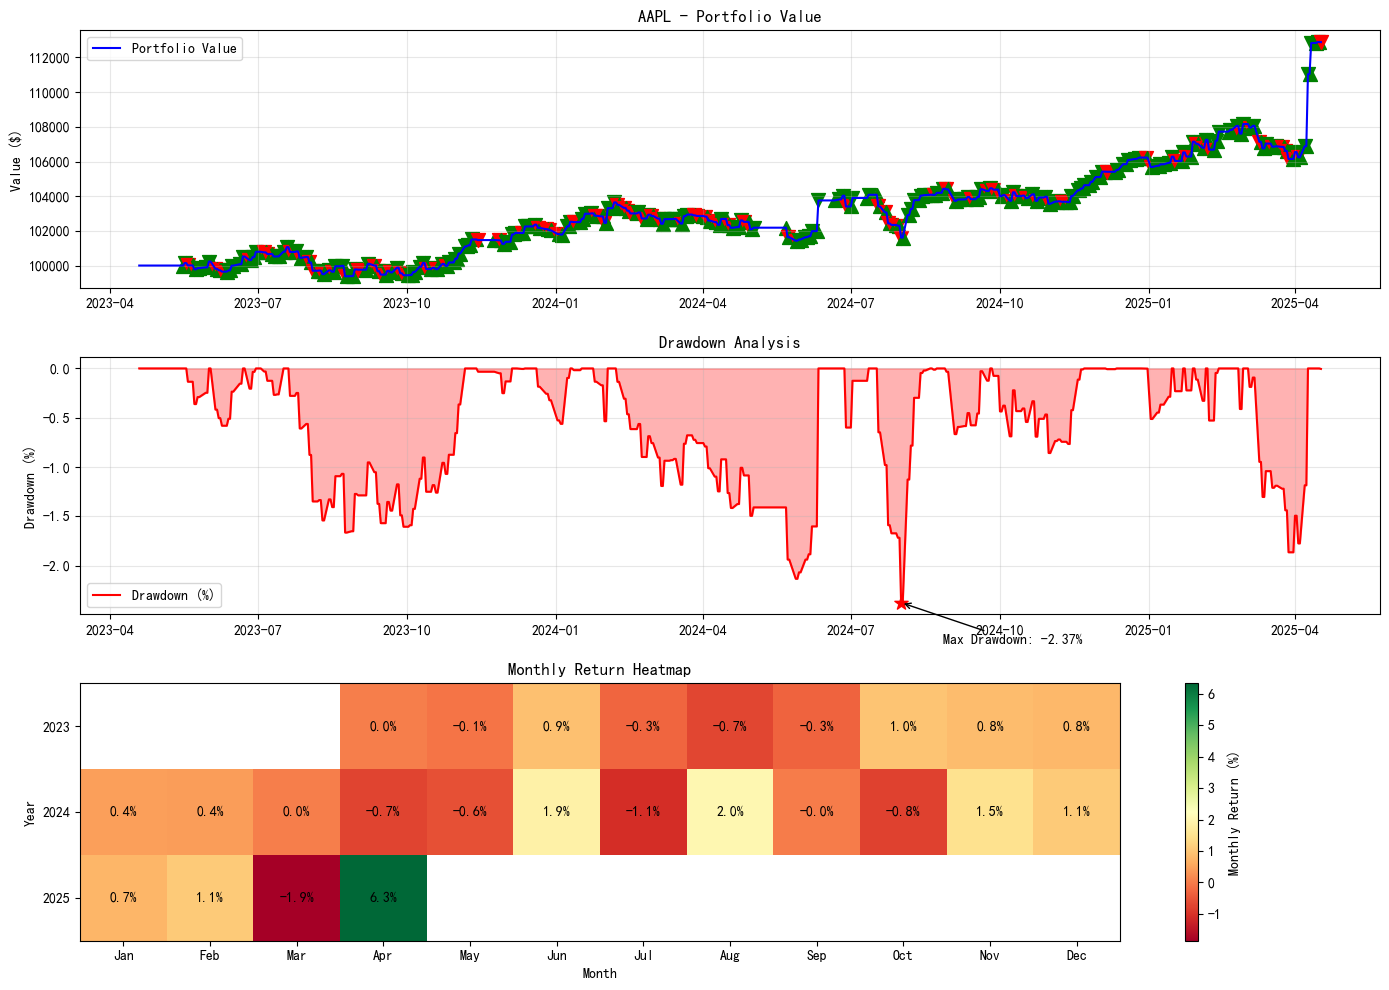

Chart 2 generated (Portfolio value, Drawdown, Monthly returns) and saved to AAPL_portfolio_performance.png


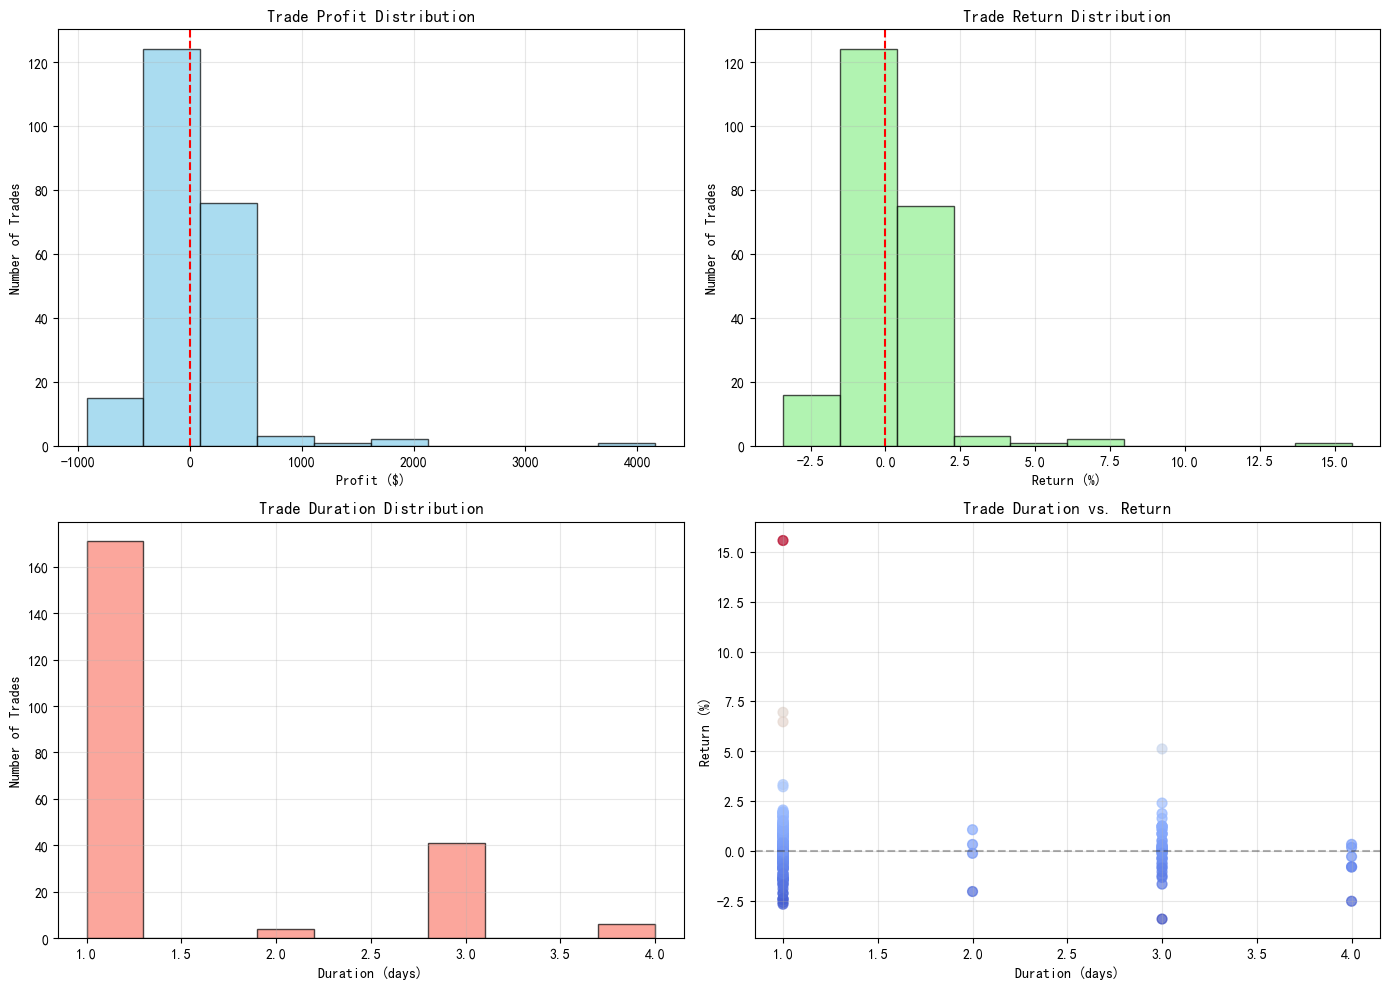

Chart 3 generated (Trade distribution) and saved to AAPL_trade_analysis.png
Advanced metrics visualization disabled.
Daily Returns - Mean: 0.02%, Std Dev: 0.28%
Max Drawdown: -2.37%

===== TRADING SIGNALS TABLE =====
Date         Action Price      RSI        BB Status       Exit Reason     Profit/Loss  Return     Duration  
--------------------------------------------------------------------------------------------------------------
2023-05-16   Buy    $171.71    58.7       5.9% from BB Lower Unknown         $142.68      0.57%      1 days    
2023-05-18   Buy    $176.11    66.6       7.6% from BB Lower Unknown         $-135.05     -0.54%     1 days    
2023-05-22   Buy    $173.13    62.4       6.3% from BB Lower Unknown         $-226.73     -0.91%     1 days    
2023-05-24   Buy    $172.50    53.0       3.2% from BB Lower Unknown         $70.86       0.28%      1 days    
2023-05-26   Buy    $176.99    62.9       4.9% from BB Lower Unknown         $43.72       0.18%      4 days    
202

In [50]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
Buy Low / Sell High Strategy with:
1) Multi-parameter Tuning & Advanced Visualization (From the Second Version)
2) Unified Exception Handling
3) analyze_trades Function (From the First Version, migrated and optimized)
"""

import functools
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shinybroker as sb   # Replace with actual data interface if needed
import datetime
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

# Configure matplotlib settings
matplotlib.rcParams['font.family'] = ['SimHei']  # Adjust if needed
matplotlib.rcParams['axes.unicode_minus'] = False

current_date = pd.Timestamp.now()
print(f"Current date/time: {current_date}")

# --------------------------
# 0. Unified Exception Handling Decorator
# --------------------------
def safe(func):
    """Decorator for unified exception handling."""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            print(f"Error in {func.__name__}: {e}")
            # 使用更简洁的方式返回空值
            if 'backtest' in func.__name__:
                return pd.DataFrame(), []
            else:
                return pd.DataFrame() if 'data' in func.__name__ or 'indicators' in func.__name__ else None
    return wrapper


# --------------------------
# 1. Data Fetching
# --------------------------
@safe
def fetch_asset_data(symbol, duration="12 M", bar_size="1 day"):
    """
    Fetch historical data for the specified symbol from shinybroker (or other data source).
    Returns a DataFrame with columns: [Date, Open, High, Low, Close, Volume].
    """
    print(f"Fetching data for {symbol}...")
    asset = sb.Contract({
        'symbol': symbol,
        'secType': "STK",
        'exchange': "SMART",
        'currency': "USD"
    })
    data = sb.fetch_historical_data(contract=asset, barSizeSetting=bar_size, durationStr=duration)['hst_dta']
    data.reset_index(inplace=True)
    data['Date'] = pd.to_datetime(data['timestamp']).dt.tz_localize(None)
    data = data[data['Date'] <= current_date]
    data = data.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'})
    return data


@safe
def fetch_benchmark_data(benchmark="SPY", duration="12 M", bar_size="1 day"):
    """
    Fetch benchmark data (typically SPY) for performance comparison.
    Returns a Series of daily returns indexed by date.
    """
    print(f"Fetching benchmark data for {benchmark}...")
    try:
        # Use same data fetching as assets
        benchmark_data = fetch_asset_data(benchmark, duration, bar_size)
        if benchmark_data.empty:
            print("No benchmark data available.")
            return pd.Series()

        # Calculate daily returns
        benchmark_data['Date'] = pd.to_datetime(benchmark_data['Date'])
        benchmark_data.set_index('Date', inplace=True)
        benchmark_returns = benchmark_data['Close'].pct_change().dropna()

        return benchmark_returns
    except Exception as e:
        print(f"Error fetching benchmark data: {e}")
        return pd.Series()


# --------------------------
# 2. Technical Indicators
# --------------------------
@safe
def add_indicators(df):
    """
    Add various technical indicators (SMA, MACD, RSI, Bollinger Bands, ATR, OBV) to the DataFrame.
    """
    print("Adding technical indicators...")
    df = df.copy()
    df['SMA20'] = ta.trend.sma_indicator(df["Close"], window=20, fillna=True)
    df['SMA50'] = ta.trend.sma_indicator(df["Close"], window=50, fillna=True)
    df['SMA200'] = ta.trend.sma_indicator(df["Close"], window=200, fillna=True)
    df['MACD'] = ta.trend.macd_diff(df["Close"], window_slow=26, window_fast=12, window_sign=9, fillna=True)
    df['RSI'] = ta.momentum.rsi(df["Close"], window=14, fillna=True)

    bb = ta.volatility.BollingerBands(df["Close"], window=20, window_dev=2)
    df['BB_Upper'] = bb.bollinger_hband()
    df['BB_Lower'] = bb.bollinger_lband()
    df['BB_Middle'] = bb.bollinger_mavg()

    df['ATR'] = ta.volatility.average_true_range(df["High"], df["Low"], df["Close"], window=14, fillna=True)
    df['OBV'] = ta.volume.on_balance_volume(df["Close"], df["Volume"], fillna=True)
    return df


# --------------------------
# 3. Generate Trading Signals
# --------------------------
@safe
def generate_signals(df,
                     rsi_threshold=70,
                     atr_stop_multiplier=1.5,
                     atr_take_multiplier=3.5,
                     risk_per_trade=0.012,
                     min_size=0.10,
                     max_size=0.25):
    """
    Strategy C+: Dynamic position sizing leaning towards Strategy B
      - Position = clamp(dynamic risk position, 10%, 25%)
      - Other logic same as Strategy C (Breakeven, Trailing, Entry conditions)
    """
    df_signals = df.copy()
    # Initialize
    df_signals['Signal']        = 0
    df_signals['Entry_Price']   = np.nan
    df_signals['Stop_Loss']     = np.nan
    df_signals['Take_Profit']   = np.nan
    df_signals['Position_Size'] = 0.0

    bb_th = 0.05
    n = len(df_signals)

    for i in range(1, n - 1):
        # —— Position Management ——
        if df_signals.iloc[i-1]['Signal'] == 1:
            entry = df_signals.iloc[i-1]['Entry_Price']
            atr   = df_signals.iloc[i-1]['ATR']
            stop  = df_signals.iloc[i-1]['Stop_Loss']
            take  = df_signals.iloc[i-1]['Take_Profit']

            # Breakeven
            if df_signals.iloc[i]['High'] >= entry:
                stop = max(stop, entry)
            # Trailing
            if df_signals.iloc[i]['High'] >= entry + 2 * atr:
                stop = max(stop, entry + atr)
            df_signals.iat[i, df_signals.columns.get_loc('Stop_Loss')] = stop

            # Static SL/TP
            if df_signals.iloc[i]['Low'] <= stop or df_signals.iloc[i]['High'] >= take:
                df_signals.iat[i, df_signals.columns.get_loc('Signal')] = 0
                continue

        # —— Carry Forward Position ——
        if df_signals.iloc[i-1]['Signal'] != 0:
            for col in ['Signal', 'Entry_Price', 'Stop_Loss', 'Take_Profit', 'Position_Size']:
                df_signals.iat[i, df_signals.columns.get_loc(col)] = df_signals.iloc[i-1][col]
            continue

        # —— New Entry Logic ——
        close  = df_signals.iloc[i]['Close']
        rsi    = df_signals.iloc[i]['RSI']
        bb_lo  = df_signals.iloc[i]['BB_Lower']
        bb_md  = df_signals.iloc[i]['BB_Middle']
        sma20  = df_signals.iloc[i]['SMA20']

        cond_main     = (rsi < rsi_threshold and close <= bb_lo * (1 + bb_th))
        cond_mid      = (close <= bb_md * (1 + bb_th))
        cond_oversold = (rsi < 30)
        cond_sma20    = (close <= sma20 * 0.98)

        if cond_main or cond_mid or cond_oversold or cond_sma20:
            entry_price = df_signals.iloc[i+1]['Open']
            atr_value   = df_signals.iloc[i]['ATR']
            if atr_value <= 0:
                continue

            # Dynamic risk position sizing
            port_val = df_signals.iloc[i-1].get('Portfolio_Value', 100000)
            risk_amt = risk_per_trade * port_val
            dyn_pct  = risk_amt / (atr_stop_multiplier * atr_value * entry_price)

            # Clamp to [min_size, max_size]
            pos_pct = max(min_size, min(dyn_pct, max_size))

            df_signals.iat[i, df_signals.columns.get_loc('Signal')]        = 1
            df_signals.iat[i, df_signals.columns.get_loc('Entry_Price')]   = entry_price
            df_signals.iat[i, df_signals.columns.get_loc('Stop_Loss')]     = entry_price - atr_stop_multiplier * atr_value
            df_signals.iat[i, df_signals.columns.get_loc('Take_Profit')]   = entry_price + atr_take_multiplier * atr_value
            df_signals.iat[i, df_signals.columns.get_loc('Position_Size')] = pos_pct

    return df_signals





# --------------------------
# 4. Backtesting
# --------------------------
@safe
def backtest_strategy(df_signals, verbose=True):
    """
    Backtest the generated signals and compute portfolio values, returns, drawdown, etc.
    """
    if verbose:
        print("Backtesting strategy...")
    df_backtest = df_signals.copy()
    df_backtest['Portfolio_Value'] = 100000.0
    df_backtest['Shares'] = 0.0
    df_backtest['Trade_Profit'] = 0.0
    df_backtest['Trade_Return'] = 0.0
    df_backtest['Cash'] = 100000.0  # Initialize cash to initial capital
    df_backtest['Equity'] = 0.0     # Initialize stock value to 0

    current_position, entry_price, shares_held = 0, 0, 0
    trades = []
    winning_trades = 0
    total_trades = 0

    for i in range(1, len(df_backtest)):
        # Copy forward portfolio value
        df_backtest.iloc[i, df_backtest.columns.get_loc('Portfolio_Value')] = df_backtest.iloc[i-1]['Portfolio_Value']
        df_backtest.iloc[i, df_backtest.columns.get_loc('Cash')] = df_backtest.iloc[i-1]['Cash']
        df_backtest.iloc[i, df_backtest.columns.get_loc('Equity')] = df_backtest.iloc[i-1]['Equity']

        # Enter position
        if df_backtest.iloc[i]['Signal'] != 0 and current_position == 0:
            current_position = df_backtest.iloc[i]['Signal']
            entry_price = df_backtest.iloc[i]['Entry_Price']
            try:
                position_value = df_backtest.iloc[i-1]['Portfolio_Value'] * df_backtest.iloc[i]['Position_Size']
                shares_held = position_value / entry_price

                # Update cash and equity values
                df_backtest.iloc[i, df_backtest.columns.get_loc('Cash')] = df_backtest.iloc[i]['Cash'] - position_value
                df_backtest.iloc[i, df_backtest.columns.get_loc('Equity')] = shares_held * entry_price

            except Exception as e:
                if verbose:
                    print(f"Error calculating shares at index {i}: {e}")
                continue
            df_backtest.iloc[i, df_backtest.columns.get_loc('Shares')] = shares_held

        # Exit position
        elif df_backtest.iloc[i]['Signal'] == 0 and current_position != 0:
            # Check if stop loss or take profit is triggered, use actual trigger price
            exit_price = df_backtest.iloc[i]['Close']  # Default to using closing price
            exit_reason = "Unknown"

            # Stop loss check - if daily low touches or falls below stop loss price, use stop loss price to exit
            if df_backtest.iloc[i]['Low'] <= df_backtest.iloc[i-1]['Stop_Loss']:
                exit_price = df_backtest.iloc[i-1]['Stop_Loss']
                exit_reason = "Stop_Loss"
                if verbose and i % 20 == 0:
                    print(f"Stop loss triggered: exit at ${exit_price:.2f}")

            # Take profit check - if daily high touches or exceeds take profit price, use take profit price to exit
            elif df_backtest.iloc[i]['High'] >= df_backtest.iloc[i-1]['Take_Profit']:
                exit_price = df_backtest.iloc[i-1]['Take_Profit']
                exit_reason = "Take_Profit"
                if verbose and i % 20 == 0:
                    print(f"Take profit triggered: exit at ${exit_price:.2f}")

            # RSI check
            elif 'RSI' in df_backtest.columns and df_backtest.iloc[i]['RSI'] > 70:
                exit_reason = "RSI_Overbought"

            # SMA breakout check
            elif 'SMA50' in df_backtest.columns and df_backtest.iloc[i]['Close'] < df_backtest.iloc[i]['SMA50']:
                exit_reason = "SMA_Breakdown"

            trade_profit = (exit_price - entry_price) * shares_held if current_position == 1 else 0
            new_value = df_backtest.iloc[i-1]['Portfolio_Value'] + trade_profit
            df_backtest.iloc[i, df_backtest.columns.get_loc('Portfolio_Value')] = float(new_value)
            df_backtest.iloc[i, df_backtest.columns.get_loc('Trade_Profit')] = float(trade_profit)
            trade_return = trade_profit / (entry_price * shares_held) if shares_held > 0 else 0
            df_backtest.iloc[i, df_backtest.columns.get_loc('Trade_Return')] = float(trade_return)

            # Update cash and equity values
            cash_after_exit = df_backtest.iloc[i]['Cash'] + (exit_price * shares_held)
            df_backtest.iloc[i, df_backtest.columns.get_loc('Cash')] = cash_after_exit
            df_backtest.iloc[i, df_backtest.columns.get_loc('Equity')] = 0.0  # Equity is 0 after position is closed

            trades.append({
                'Entry_Date': df_backtest.iloc[i-1]['Date'],
                'Exit_Date': df_backtest.iloc[i]['Date'],
                'Entry_Price': entry_price,
                'Exit_Price': exit_price,
                'Shares': shares_held,
                'Profit': trade_profit,
                'Return': trade_return,
                'Duration': (df_backtest.iloc[i]['Date'] - df_backtest.iloc[i-1]['Date']).days,
                'Exit_Reason': exit_reason
            })
            total_trades += 1
            if trade_profit > 0:
                winning_trades += 1

            # Reset position
            current_position, entry_price, shares_held = 0, 0, 0
            df_backtest.iloc[i, df_backtest.columns.get_loc('Shares')] = 0.0

        # If continuing the same position
        elif df_backtest.iloc[i]['Signal'] != 0 and current_position != 0:
            df_backtest.iloc[i, df_backtest.columns.get_loc('Shares')] = shares_held
            # Update equity based on latest price
            current_equity = shares_held * df_backtest.iloc[i]['Close']
            df_backtest.iloc[i, df_backtest.columns.get_loc('Equity')] = current_equity
            # Update portfolio value
            df_backtest.iloc[i, df_backtest.columns.get_loc('Portfolio_Value')] = df_backtest.iloc[i]['Cash'] + current_equity

    # Add required columns for print_ledger function
    df_backtest['Account_Value'] = df_backtest['Portfolio_Value']

    # Simple summary without detailed calculations
    if verbose:
        win_rate = winning_trades / total_trades if total_trades > 0 else 0
        print(f"\nBacktest Summary: {total_trades} trades completed with {win_rate:.2%} win rate")

    return df_backtest, trades


# --------------------------
# 5. analyze_trades (migrated & optimized from the First Version)
# --------------------------
@safe
def analyze_trades(trades, verbose=True):
    """
    Detailed analysis of all completed trades:
    - Number of trades, Win rate
    - Average profit, average win, average loss
    - Profit factor
    - Consecutive wins/losses
    - Holding duration stats
    - Recent trades summary
    """
    if not trades:
        if verbose:
            print("No trade records to analyze.")
        return None

    trades_df = pd.DataFrame(trades)
    total_trades = len(trades_df)
    win_count = len(trades_df[trades_df['Profit'] > 0])
    loss_count = len(trades_df[trades_df['Profit'] <= 0])
    win_rate = win_count / total_trades if total_trades else 0

    avg_profit = trades_df['Profit'].mean()
    avg_win = trades_df.loc[trades_df['Profit'] > 0, 'Profit'].mean() if win_count > 0 else 0
    avg_loss = trades_df.loc[trades_df['Profit'] <= 0, 'Profit'].mean() if loss_count > 0 else 0

    # Profit factor = sum of all wins / sum of all losses (absolute value)
    total_win_amount = trades_df.loc[trades_df['Profit'] > 0, 'Profit'].sum()
    total_loss_amount = trades_df.loc[trades_df['Profit'] < 0, 'Profit'].sum()
    profit_factor = abs(total_win_amount / total_loss_amount) if total_loss_amount != 0 else float('inf')

    # Duration
    trades_df['Duration'] = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days
    avg_duration = trades_df['Duration'].mean()
    max_duration = trades_df['Duration'].max()
    min_duration = trades_df['Duration'].min()

    # Analyze consecutive wins/losses
    trade_results = [1 if p > 0 else 0 for p in trades_df['Profit']]

    # Calculate max consecutive wins (inline function)
    max_consecutive_wins = 0
    current_count = 0
    for v in trade_results:
        if v == 1:
            current_count += 1
            max_consecutive_wins = max(max_consecutive_wins, current_count)
        else:
            current_count = 0

    # Calculate max consecutive losses (inline function)
    max_consecutive_losses = 0
    current_count = 0
    for v in trade_results:
        if v == 0:
            current_count += 1
            max_consecutive_losses = max(max_consecutive_losses, current_count)
        else:
            current_count = 0

    if verbose:
        print("\n=== Detailed Trade Analysis ===")
        print(f"Total Trades: {total_trades}")
        print(f"Win Rate: {win_rate:.2%}  (Wins={win_count}, Losses={loss_count})")
        print(f"Avg Trade Profit: {avg_profit:.2f}")
        print(f"Avg Win: {avg_win:.2f},  Avg Loss: {avg_loss:.2f}")
        print(f"Profit Factor: {profit_factor:.2f}")
        print(f"Avg Holding Duration: {avg_duration:.1f} days  (Max={max_duration}d, Min={min_duration}d)")
        print(f"Max Consecutive Wins: {max_consecutive_wins}")
        print(f"Max Consecutive Losses: {max_consecutive_losses}")

        # Recent trades
        print("\nRecent 10 Trades (most recent first):")
        recent_trades = trades_df.tail(10).sort_values('Entry_Date', ascending=False)
        for i, trade in recent_trades.iterrows():
            result_str = "Profit" if trade['Profit'] > 0 else "Loss"
            print(f"  {trade['Entry_Date'].date()} -> {trade['Exit_Date'].date()} ({trade['Duration']} days): "
                f"${trade['Entry_Price']:.2f} -> ${trade['Exit_Price']:.2f}, {result_str} ${abs(trade['Profit']):.2f}, "
                f"Return={trade['Return']*100:.2f}%")

    return trades_df


# --------------------------
# 6. Parameter Optimization & Visualization
# --------------------------
@safe
def optimize_strategy(df, param_grid=None, min_trades=10, drawdown_penalty=0.5):
    """
    Grid-search parameter optimization with:
      - Extended parameter range
      - Skip combinations with < min_trades trades
      - Custom scoring: Sharpe - drawdown_penalty * abs(max_drawdown)
    """
    print("Starting enhanced parameter optimization...")
    # 1) Default richer parameter grid
    if param_grid is None:
        param_grid = {
            'rsi_threshold': [30, 35, 40, 45, 50, 55],
            'atr_stop_multiplier': [1.0, 1.5, 2.0, 2.5, 3.0],
            'atr_take_multiplier': [2.0, 3.0, 4.0, 5.0, 6.0]
        }

    # 2) Scoring function: Sharpe minus drawdown penalty
    def score_fn(res):
        return res['sharpe_ratio'] - drawdown_penalty * abs(res['max_drawdown'] / 100)

    best_score = -float('inf')
    best_params = None
    all_results = []

    # Full traversal
    for rsi_thresh in param_grid['rsi_threshold']:
        for atr_stop in param_grid['atr_stop_multiplier']:
            for atr_take in param_grid['atr_take_multiplier']:
                # Ensure take profit > stop loss
                if atr_take <= atr_stop:
                    continue

                # Generate signals and backtest
                signals = generate_signals(df, rsi_thresh, atr_stop, atr_take)
                backtested, trades = backtest_strategy(signals, verbose=False)

                # Filter out trades with too few trades
                if len(trades) < min_trades:
                    continue

                # Calculate metrics
                initial = backtested['Portfolio_Value'].iloc[0]
                final   = backtested['Portfolio_Value'].iloc[-1]
                total_ret = (final / initial - 1) * 100
                days = (backtested['Date'].iloc[-1] - backtested['Date'].iloc[0]).days
                years = days / 365 if days>0 else 0
                ann_ret = ((1 + total_ret/100) ** (1/years) - 1) * 100 if years>0 else 0
                backtested['Peak'] = backtested['Portfolio_Value'].cummax()
                backtested['Drawdown'] = (backtested['Portfolio_Value'] / backtested['Peak'] - 1) * 100
                max_dd = backtested['Drawdown'].min()
                returns = backtested['Portfolio_Value'].pct_change().dropna()
                sharpe = (ann_ret/100) / (returns.std() * np.sqrt(252)) if returns.std()>0 else 0
                win_rate = len([t for t in trades if t['Profit']>0]) / len(trades)

                res = {
                    'rsi_threshold': rsi_thresh,
                    'atr_stop_multiplier': atr_stop,
                    'atr_take_multiplier': atr_take,
                    'total_trades': len(trades),
                    'win_rate': win_rate,
                    'total_return': total_ret,
                    'annualized_return': ann_ret,
                    'max_drawdown': max_dd,
                    'sharpe_ratio': sharpe
                }
                all_results.append(res)

                # 3) Use custom score to select best
                s = score_fn(res)
                if s > best_score:
                    best_score = s
                    best_params = (rsi_thresh, atr_stop, atr_take)

    # Output results
    results_df = pd.DataFrame(all_results)
    if best_params:
        print(f"\nEnhanced Best Parameters: RSI={best_params[0]}, "
              f"ATR Stop={best_params[1]}, ATR Take={best_params[2]}, Score={best_score:.2f}")
    else:
        print("No valid parameter combination found under constraints.")

    visualize_optimization_results(results_df)
    return best_params, results_df


def visualize_optimization_results(results_df):
    """
    Visualization of optimization results:
      1) Heatmap of Sharpe Ratio by RSI vs. ATR Stop
      2) Scatter of RSI vs. ATR Take (color=annualized return, size=win rate)
      3) Correlation Heatmap
      4) Risk-Return Scatter (max drawdown vs. total return), highlighting best Sharpe
    """
    if results_df is None or results_df.empty or len(results_df) < 2:
        print("Not enough optimization results for visualization.")
        return

    print("Parameter optimization results available but visualization disabled.")
    print(f"Best parameters from optimization process (Note: optimization Sharpe differs from final backtest): ", end="")

    if 'sharpe_ratio' in results_df.columns and not results_df.empty:
        best_idx = results_df['sharpe_ratio'].idxmax()
        best_row = results_df.loc[best_idx]
        print(f"RSI={best_row['rsi_threshold']}, "
              f"ATR Stop={best_row['atr_stop_multiplier']}, "
              f"ATR Take={best_row['atr_take_multiplier']}, "
              f"Optimization Sharpe={best_row['sharpe_ratio']:.2f}")
    else:
        print("No valid Sharpe ratio data found.")


# --------------------------
# 7. Comprehensive Visualization
# --------------------------
@safe
def visualize_results(df, df_backtest, trades, symbol):
    """
    Plot:
      - Price/MAs/Bollinger + signals + RSI
      - Portfolio Value & Drawdown
      - Monthly returns heatmap
      - Trade distribution charts (profit, return, duration, etc.)
    """
    print("Generating comprehensive strategy visualizations...")
    trades_df = pd.DataFrame(trades) if trades else pd.DataFrame()

    try:
        # --- Chart 1: Price, MAs, Bollinger, RSI, signals
        plt.figure(figsize=(14, 7))
        # 1A) Price + signals
        plt.subplot(2, 1, 1)
        plt.plot(df_backtest['Date'], df_backtest['Close'], label='Close')
        plt.plot(df_backtest['Date'], df_backtest['SMA20'], 'g--', label='SMA20', alpha=0.6)
        plt.plot(df_backtest['Date'], df_backtest['SMA50'], 'r--', label='SMA50', alpha=0.6)
        plt.plot(df_backtest['Date'], df_backtest['SMA200'], 'b--', label='SMA200', alpha=0.6)

        plt.plot(df_backtest['Date'], df_backtest['BB_Upper'], 'g-', alpha=0.3)
        plt.plot(df_backtest['Date'], df_backtest['BB_Lower'], 'g-', alpha=0.3)
        plt.fill_between(df_backtest['Date'], df_backtest['BB_Upper'],
                        df_backtest['BB_Lower'], color='g', alpha=0.1, label='Bollinger Bands')

        buy_signals = df_backtest[df_backtest['Signal'] == 1]
        plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='g', s=100, label='Buy Signal')

        exit_signals = df_backtest[(df_backtest['Signal'] == 0) & (df_backtest['Trade_Profit'] != 0)]
        plt.scatter(exit_signals['Date'], exit_signals['Close'], marker='v', color='r', s=100, label='Sell Signal')

        plt.title(f'{symbol} - Trading Signals')
        plt.ylabel('Price ($)')
        plt.legend(loc='upper left')
        plt.grid(alpha=0.3)

        # 1B) RSI
        plt.subplot(2, 1, 2)
        plt.plot(df_backtest['Date'], df_backtest['RSI'], label='RSI')
        plt.axhline(70, color='r', linestyle='-', alpha=0.3, label='Overbought (70)')
        plt.axhline(40, color='g', linestyle='-', alpha=0.3, label='Oversold (40)')
        plt.fill_between(df_backtest['Date'], 0, 40, color='g', alpha=0.1)
        plt.fill_between(df_backtest['Date'], 70, 100, color='r', alpha=0.1)

        if not buy_signals.empty:
            plt.scatter(buy_signals['Date'], buy_signals['RSI'], marker='^', color='g', s=100)
        if not exit_signals.empty:
            plt.scatter(exit_signals['Date'], exit_signals['RSI'], marker='v', color='r', s=100)

        plt.title('RSI and Signals')
        plt.xlabel('Date')
        plt.ylabel('RSI')
        plt.legend(loc='upper left')
        plt.grid(alpha=0.3)

        plt.tight_layout()
        chart1_filename = f'{symbol}_trading_signals.png'
        plt.savefig(chart1_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Chart 1 generated (Price & RSI with signals) and saved to {chart1_filename}")
        plt.close()

        # --- Chart 2: Portfolio Value & Drawdown & Monthly Returns
        plt.figure(figsize=(14, 10))
        # 2A) Portfolio
        plt.subplot(3, 1, 1)
        plt.plot(df_backtest['Date'], df_backtest['Portfolio_Value'], label='Portfolio Value', color='blue')
        for trade in trades:
            # Mark entry
            plt.scatter(trade['Entry_Date'],
                        df_backtest[df_backtest['Date'] == trade['Entry_Date']]['Portfolio_Value'].values[0],
                        marker='^', color='g', s=100)
            # Mark exit
            marker_color = 'g' if trade['Profit'] > 0 else 'r'
            plt.scatter(trade['Exit_Date'],
                        df_backtest[df_backtest['Date'] == trade['Exit_Date']]['Portfolio_Value'].values[0],
                        marker='v', color=marker_color, s=100)
        plt.title(f'{symbol} - Portfolio Value')
        plt.ylabel('Value ($)')
        plt.legend()
        plt.grid(alpha=0.3)

        # 2B) Drawdown
        plt.subplot(3, 1, 2)
        df_backtest['Peak'] = df_backtest['Portfolio_Value'].cummax()
        df_backtest['Drawdown'] = (df_backtest['Portfolio_Value'] / df_backtest['Peak'] - 1) * 100
        plt.fill_between(df_backtest['Date'], 0, df_backtest['Drawdown'], color='r', alpha=0.3)
        plt.plot(df_backtest['Date'], df_backtest['Drawdown'], 'r', label='Drawdown (%)')
        max_dd_idx = df_backtest['Drawdown'].idxmin()
        max_dd = df_backtest.iloc[max_dd_idx]['Drawdown']
        max_dd_date = df_backtest.iloc[max_dd_idx]['Date']
        plt.scatter([max_dd_date], [max_dd], color='r', s=100, marker='*')
        plt.annotate(f'Max Drawdown: {max_dd:.2f}%', xy=(max_dd_date, max_dd), xytext=(30, -30),
                    textcoords='offset points', arrowprops=dict(arrowstyle='->', color='black'))
        plt.title('Drawdown Analysis')
        plt.ylabel('Drawdown (%)')
        plt.legend()
        plt.grid(alpha=0.3)

        # 2C) Monthly Returns Heatmap
        plt.subplot(3, 1, 3)
        df_backtest['Daily_Return'] = df_backtest['Portfolio_Value'].pct_change()
        df_backtest['Year'] = df_backtest['Date'].dt.year
        df_backtest['Month'] = df_backtest['Date'].dt.month
        monthly_returns = df_backtest.groupby(['Year', 'Month'])['Daily_Return'].apply(lambda x: (1 + x).prod() - 1).reset_index()
        monthly_returns['Monthly_Return_%'] = monthly_returns['Daily_Return'] * 100
        pivot_mr = monthly_returns.pivot(index='Year', columns='Month', values='Monthly_Return_%')

        im = plt.imshow(pivot_mr, cmap='RdYlGn', aspect='auto')
        plt.colorbar(im, label='Monthly Return (%)')
        plt.title('Monthly Return Heatmap')
        plt.xlabel('Month')
        plt.ylabel('Year')
        plt.xticks(range(12), ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
        plt.yticks(range(len(pivot_mr.index)), pivot_mr.index)
        for i in range(pivot_mr.shape[0]):
            for j in range(pivot_mr.shape[1]):
                val = pivot_mr.iloc[i, j]
                if not np.isnan(val):
                    plt.text(j, i, f'{val:.1f}%', ha='center', va='center',
                            color='black' if abs(val) < 8 else 'white')

        plt.tight_layout()
        chart2_filename = f'{symbol}_portfolio_performance.png'
        plt.savefig(chart2_filename, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Chart 2 generated (Portfolio value, Drawdown, Monthly returns) and saved to {chart2_filename}")
        plt.close()

        # --- Chart 3: Trade-level distribution analysis
        if not trades_df.empty:
            plt.figure(figsize=(14, 10))

            plt.subplot(2, 2, 1)
            plt.hist(trades_df['Profit'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
            plt.axvline(0, color='r', linestyle='--')
            plt.title('Trade Profit Distribution')
            plt.xlabel('Profit ($)')
            plt.ylabel('Number of Trades')
            plt.grid(alpha=0.3)

            plt.subplot(2, 2, 2)
            plt.hist(trades_df['Return'] * 100, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
            plt.axvline(0, color='r', linestyle='--')
            plt.title('Trade Return Distribution')
            plt.xlabel('Return (%)')
            plt.ylabel('Number of Trades')
            plt.grid(alpha=0.3)

            # Duration-based stats
            if 'Entry_Date' in trades_df.columns and 'Exit_Date' in trades_df.columns:
                trades_df['Duration'] = (trades_df['Exit_Date'] - trades_df['Entry_Date']).dt.days

                plt.subplot(2, 2, 3)
                plt.hist(trades_df['Duration'], bins=10, alpha=0.7, color='salmon', edgecolor='black')
                plt.title('Trade Duration Distribution')
                plt.xlabel('Duration (days)')
                plt.ylabel('Number of Trades')
                plt.grid(alpha=0.3)

                plt.subplot(2, 2, 4)
                scatter = plt.scatter(trades_df['Duration'], trades_df['Return'] * 100,
                                    c=trades_df['Profit'], cmap='coolwarm', alpha=0.7, s=50)
                plt.axhline(0, color='k', linestyle='--', alpha=0.3)

                plt.title('Trade Duration vs. Return')
                plt.xlabel('Duration (days)')
                plt.ylabel('Return (%)')
                plt.grid(alpha=0.3)

            plt.tight_layout()
            chart3_filename = f'{symbol}_trade_analysis.png'
            plt.savefig(chart3_filename, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"Chart 3 generated (Trade distribution) and saved to {chart3_filename}")
            plt.close()
        else:
            print("No trade data for detailed trade analysis.")

    except Exception as e:
        print(f"Error in visualization: {e}")
        plt.close('all')  # Ensure all plots are closed on error


# --------------------------
# 8. Advanced Metrics Visualization
# --------------------------
@safe
def visualize_advanced_metrics(df_backtest, window=30):
    """
    Visualize:
      - Daily returns distribution
      - Drawdown distribution
      - Rolling annualized return & rolling annualized volatility
      - Rolling Sharpe ratio
    """
    if 'Portfolio_Value' not in df_backtest.columns or df_backtest.empty:
        print("No portfolio data available for advanced metrics.")
        return

    print("Advanced metrics visualization disabled.")

    # Calculate and print summary statistics instead
    if 'Daily_Return' not in df_backtest.columns:
        df_backtest['Daily_Return'] = df_backtest['Portfolio_Value'].pct_change()
    if 'Drawdown' not in df_backtest.columns:
        df_backtest['Peak'] = df_backtest['Portfolio_Value'].cummax()
        df_backtest['Drawdown'] = (df_backtest['Portfolio_Value'] / df_backtest['Peak'] - 1) * 100

    # Print some basic statistics
    daily_returns = df_backtest['Daily_Return'].dropna()
    print(f"Daily Returns - Mean: {daily_returns.mean()*100:.2f}%, Std Dev: {daily_returns.std()*100:.2f}%")
    print(f"Max Drawdown: {df_backtest['Drawdown'].min():.2f}%")


# --------------------------
# 8.1 Trade Blotter and Ledger
# --------------------------
@safe
def print_blotter(trades, detailed=False):
    """
    Print trade record book showing detailed information for all trades.
    Includes: entry date, exit date, holding days, prices, shares, profit/loss, and return rate.
    """
    if not trades:
        print("No trades to display in blotter.")
        return

    # Convert to DataFrame for analysis
    trades_df = pd.DataFrame(trades)

    # Calculate key statistics
    total_trades = len(trades_df)
    win_trades = len(trades_df[trades_df['Profit'] > 0])
    loss_trades = total_trades - win_trades
    win_rate = (win_trades / total_trades * 100) if total_trades > 0 else 0

    total_profit = trades_df['Profit'].sum()
    avg_profit = trades_df['Profit'].mean()
    avg_profit_win = trades_df[trades_df['Profit'] > 0]['Profit'].mean() if win_trades > 0 else 0
    avg_loss = trades_df[trades_df['Profit'] <= 0]['Profit'].mean() if loss_trades > 0 else 0

    max_profit = trades_df['Profit'].max() if not trades_df.empty else 0
    max_loss = trades_df['Profit'].min() if not trades_df.empty else 0

    avg_hold_days = trades_df['Duration'].mean() if 'Duration' in trades_df.columns else None

    # Calculate profit-loss ratio
    profit_loss_ratio = abs(avg_profit_win / avg_loss) if avg_loss != 0 else float('inf')

    # Calculate ROI
    initial_capital = 100000  # Assumed $100,000 initial capital
    roi = (total_profit / initial_capital) * 100

    # Print trade blotter
    print("\n" + "="*50)
    print("                  BLOTTER (TRADE RECORD)                 ")
    print("="*50)
    print("{:<12} {:<12} {:<8} {:<10} {:<10} {:<10} {:<12} {:<10} {:<15}".format(
        "Entry Date", "Exit Date", "Days", "Entry", "Exit", "Shares", "Profit/Loss", "Return", "Exit Reason"
    ))
    print("-" * 110)

    # Sort by entry date
    trades_df = trades_df.sort_values('Entry_Date')

    for _, trade in trades_df.iterrows():
        entry_date = trade['Entry_Date'].strftime('%Y-%m-%d')
        exit_date = trade['Exit_Date'].strftime('%Y-%m-%d') if pd.notna(trade['Exit_Date']) else 'Open'

        hold_days = trade['Duration'] if 'Duration' in trade else (
            (trade['Exit_Date'] - trade['Entry_Date']).days if pd.notna(trade['Exit_Date']) else 'N/A'
        )

        entry_price = f"${trade['Entry_Price']:.2f}"
        exit_price = f"${trade['Exit_Price']:.2f}" if pd.notna(trade['Exit_Price']) else 'N/A'

        shares = int(trade['Shares'])

        profit_loss = trade['Profit']
        profit_loss_str = f"${profit_loss:.2f}"

        return_pct = trade['Return'] * 100
        return_str = f"{return_pct:.2f}%"

        exit_reason = trade.get('Exit_Reason', 'N/A')

        print("{:<12} {:<12} {:<8} {:<10} {:<10} {:<10} {:<12} {:<10} {:<15}".format(
            entry_date, exit_date, hold_days, entry_price, exit_price, shares,
            profit_loss_str, return_str, exit_reason
        ))

    print("-" * 110)

    # Analyze exit reasons
    if 'Exit_Reason' in trades_df.columns and not trades_df.empty:
        reason_stats = trades_df.groupby('Exit_Reason').agg({
            'Profit': ['count', 'mean', 'sum'],
            'Return': 'mean',
            'Duration': 'mean'
        })
        reason_stats.columns = ['Count', 'Avg Profit', 'Total Profit', 'Avg Return', 'Avg Duration']

        print("\n===== EXIT REASON ANALYSIS =====")
        for reason, row in reason_stats.iterrows():
            win_count = len(trades_df[(trades_df['Exit_Reason'] == reason) & (trades_df['Profit'] > 0)])
            win_rate_reason = (win_count / row['Count']) * 100
            print(f"{reason}: {row['Count']} trades, Win Rate: {win_rate_reason:.1f}%, "
                  f"Avg Profit: ${row['Avg Profit']:.2f}, Total: ${row['Total Profit']:.2f}, "
                  f"Avg Duration: {row['Avg Duration']:.1f} days")

    # Print summary statistics
    print("\n===== TRADE STATISTICS =====")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {win_trades} ({win_rate:.1f}%)")
    print(f"Losing Trades: {loss_trades} ({100-win_rate:.1f}%)")
    print(f"Total Profit/Loss: ${total_profit:.2f}")
    print(f"Average Profit/Loss: ${avg_profit:.2f}")
    print(f"Average Win: ${avg_profit_win:.2f}")
    print(f"Average Loss: ${avg_loss:.2f}")
    print(f"Profit/Loss Ratio: {profit_loss_ratio:.2f}")
    print(f"Largest Win: ${max_profit:.2f}")
    print(f"Largest Loss: ${max_loss:.2f}")
    if avg_hold_days is not None:
        print(f"Average Holding Period: {avg_hold_days:.1f} days")
    print(f"Return on Investment (ROI): {roi:.2f}%")

    # Calculate best and worst trades
    if not trades_df.empty:
        best_trade = trades_df.loc[trades_df['Profit'].idxmax()]
        worst_trade = trades_df.loc[trades_df['Profit'].idxmin()]

        print("\n===== BEST TRADE =====")
        print(f"Date: {best_trade['Entry_Date'].strftime('%Y-%m-%d')} to {best_trade['Exit_Date'].strftime('%Y-%m-%d')}")
        print(f"Holding Days: {best_trade.get('Duration', 'N/A')} days")
        print(f"Entry Price: ${best_trade['Entry_Price']:.2f}, Exit Price: ${best_trade['Exit_Price']:.2f}")
        print(f"Shares: {int(best_trade['Shares'])}")
        print(f"Profit: ${best_trade['Profit']:.2f} ({best_trade['Return']*100:.2f}%)")
        print(f"Exit Reason: {best_trade.get('Exit_Reason', 'N/A')}")

        print("\n===== WORST TRADE =====")
        print(f"Date: {worst_trade['Entry_Date'].strftime('%Y-%m-%d')} to {worst_trade['Exit_Date'].strftime('%Y-%m-%d')}")
        print(f"Holding Days: {worst_trade.get('Duration', 'N/A')} days")
        print(f"Entry Price: ${worst_trade['Entry_Price']:.2f}, Exit Price: ${worst_trade['Exit_Price']:.2f}")
        print(f"Shares: {int(worst_trade['Shares'])}")
        print(f"Loss: ${worst_trade['Profit']:.2f} ({worst_trade['Return']*100:.2f}%)")
        print(f"Exit Reason: {worst_trade.get('Exit_Reason', 'N/A')}")

    # If detailed flag is true, add more detailed analysis
    if detailed and total_trades > 0:
        print("\n===== DETAILED ANALYSIS =====")

        # Group by month/week
        if 'Entry_Date' in trades_df.columns:
            trades_df['Month'] = trades_df['Entry_Date'].dt.strftime('%Y-%m')
            monthly_profit = trades_df.groupby('Month')['Profit'].sum()

            print("\nMonthly Profit/Loss:")
            for month, profit in monthly_profit.items():
                print(f"{month}: ${profit:.2f}")

        # Analyze consecutive wins/losses
        trade_results = [1 if p > 0 else 0 for p in trades_df['Profit']]

        # Calculate max consecutive wins (inline function)
        max_consecutive_wins = 0
        current_count = 0
        for v in trade_results:
            if v == 1:
                current_count += 1
                max_consecutive_wins = max(max_consecutive_wins, current_count)
            else:
                current_count = 0

        # Calculate max consecutive losses (inline function)
        max_consecutive_losses = 0
        current_count = 0
        for v in trade_results:
            if v == 0:
                current_count += 1
                max_consecutive_losses = max(max_consecutive_losses, current_count)
            else:
                current_count = 0

        print(f"\nMax Consecutive Wins: {max_consecutive_wins}")
        print(f"Max Consecutive Losses: {max_consecutive_losses}")

        # Show holding days distribution
        if 'Duration' in trades_df.columns:
            duration_counts = trades_df['Duration'].value_counts().sort_index()
            print("\nHolding Period Distribution:")
            for days, count in duration_counts.items():
                print(f"  {days} days: {count} trades ({count/total_trades*100:.1f}%)")


@safe
def print_ledger(portfolio, interval='D'):
    """
    Print account status and performance ledger, aggregated by specified time interval
    ('D' for daily, 'W' for weekly, 'M' for monthly).
    """
    if portfolio.empty:
        print("Portfolio data is empty, cannot generate ledger")
        return

    # Check if required columns exist
    required_cols = ['Date', 'Account_Value', 'Cash', 'Equity']
    if not all(col in portfolio.columns for col in required_cols):
        print("Missing necessary columns to generate ledger")
        print(f"Available columns: {portfolio.columns.tolist()}")
        missing = [col for col in required_cols if col not in portfolio.columns]
        print(f"Missing columns: {missing}")
        return

    try:
        # Ensure date format is correct
        if not pd.api.types.is_datetime64_any_dtype(portfolio['Date']):
            portfolio['Date'] = pd.to_datetime(portfolio['Date'])

        # Set date as index for resampling
        portfolio_resampled = portfolio.copy()
        portfolio_resampled.set_index('Date', inplace=True)

        # Resample by specified interval
        if interval in ['W', 'M']:
            portfolio_resampled = portfolio_resampled.resample(interval).last()

        # Reset index for output
        portfolio_resampled.reset_index(inplace=True)

        # Calculate cumulative return
        starting_value = portfolio_resampled['Account_Value'].iloc[0]
        portfolio_resampled['Cumulative_Return'] = ((portfolio_resampled['Account_Value'] / starting_value) - 1) * 100

        # Calculate drawdown
        portfolio_resampled['High_Value'] = portfolio_resampled['Account_Value'].cummax()
        portfolio_resampled['Drawdown'] = (portfolio_resampled['Account_Value'] / portfolio_resampled['High_Value'] - 1) * 100

        # Print account ledger
        print("\n" + "="*50)
        print("                 LEDGER (ACCOUNT BOOK)                ")
        print("="*50)
        period_label = "Daily" if interval == 'D' else ("Weekly" if interval == 'W' else "Monthly")
        print(f"Period: {period_label}")
        print("{:<12} {:<15} {:<15} {:<15} {:<15} {:<15}".format(
            "Date", "Account($)", "Cash($)", "Equity($)", "Drawdown(%)", "Return(%)"
        ))
        print("-" * 90)

        # Output each row
        for _, row in portfolio_resampled.iterrows():
            print("{:<12} {:<15.2f} {:<15.2f} {:<15.2f} {:<15.2f} {:<15.2f}".format(
                row['Date'].strftime('%Y-%m-%d'),
                row['Account_Value'],
                row['Cash'],
                row['Equity'],
                row['Drawdown'],
                row['Cumulative_Return']
            ))

        print("-" * 90)

        # Print summary statistics
        max_drawdown = portfolio_resampled['Drawdown'].min()
        final_return = portfolio_resampled['Cumulative_Return'].iloc[-1]
        print(f"Initial Account Value: ${starting_value:.2f}")
        print(f"Final Account Value: ${portfolio_resampled['Account_Value'].iloc[-1]:.2f}")
        print(f"Total Return: {final_return:.2f}%")
        print(f"Maximum Drawdown: {max_drawdown:.2f}%")

    except Exception as e:
        print(f"Error generating ledger: {e}")
        return


# --------------------------
# 8.3 Trading Signals Table
# --------------------------
@safe
def print_trading_signals(df_signals, trades):
    """
    Print formatted trading signals table showing all trades' entry reasons and results.
    Includes: date, action, price, reason, result, profit/loss, and return rate.
    """
    if not trades:
        print("No trade records to display in trading signals table.")
        return

    print("\n===== TRADING SIGNALS TABLE =====")
    print("{:<12} {:<6} {:<10} {:<10} {:<15} {:<15} {:<12} {:<10} {:<10}".format(
        "Date", "Action", "Price", "RSI", "BB Status", "Exit Reason", "Profit/Loss", "Return", "Duration"
    ))
    print("-" * 110)

    trades_df = pd.DataFrame(trades)
    # Sort by entry date
    trades_df = trades_df.sort_values('Entry_Date')

    for _, trade in trades_df.iterrows():
        entry_date = trade['Entry_Date'].strftime('%Y-%m-%d')
        entry_price = f"${trade['Entry_Price']:.2f}"

        # Get RSI value and BB status on the trade date
        entry_date_obj = trade['Entry_Date']
        entry_row = df_signals[df_signals['Date'] == entry_date_obj]

        rsi_value = "N/A"
        bb_status = "N/A"

        if not entry_row.empty:
            if 'RSI' in entry_row.columns:
                rsi_value = f"{entry_row['RSI'].values[0]:.1f}"

            if 'Close' in entry_row.columns and 'BB_Lower' in entry_row.columns:
                close_price = entry_row['Close'].values[0]
                bb_lower = entry_row['BB_Lower'].values[0]
                price_to_bb = (close_price / bb_lower - 1) * 100
                bb_status = f"{price_to_bb:.1f}% from BB Lower"

        # Exit reason
        exit_reason = trade.get('Exit_Reason', 'Unknown')

        # Set profit/loss and return rate
        profit_loss = trade['Profit']
        profit_loss_str = f"${profit_loss:.2f}"

        return_pct = trade['Return'] * 100
        return_str = f"{return_pct:.2f}%"

        # Duration
        duration = f"{trade.get('Duration', 'N/A')} days"

        print("{:<12} {:<6} {:<10} {:<10} {:<15} {:<15} {:<12} {:<10} {:<10}".format(
            entry_date, "Buy", entry_price, rsi_value, bb_status, exit_reason,
            profit_loss_str, return_str, duration
        ))

    print("-" * 110)

    # Add more detailed trade statistics
    if len(trades_df) > 0:
        win_trades = len(trades_df[trades_df['Profit'] > 0])
        print(f"Total Trades: {len(trades_df)}")
        print(f"Win Rate: {win_trades/len(trades_df)*100:.1f}%")

        # Analyze by exit reason
        if 'Exit_Reason' in trades_df.columns:
            reason_stats = trades_df.groupby('Exit_Reason').agg({
                'Profit': ['count', 'mean', 'sum'],
                'Return': 'mean',
                'Duration': 'mean'
            })

            if not reason_stats.empty:
                print("\nExit Reason Analysis:")
                for reason, stats in reason_stats.iterrows():
                    count = stats[('Profit', 'count')]
                    avg_profit = stats[('Profit', 'mean')]
                    total_profit = stats[('Profit', 'sum')]
                    avg_return = stats[('Return', 'mean')] * 100
                    avg_duration = stats[('Duration', 'mean')]

                    print(f"  {reason}: {count} trades, Average Profit: ${avg_profit:.2f}, "
                          f"Total Profit: ${total_profit:.2f}, Average Return: {avg_return:.1f}%, "
                          f"Average Duration: {avg_duration:.1f} days")


# --------------------------
# 8.4 Performance Statistics
# --------------------------
@safe
def print_performance_statistics(df_backtest, trades, benchmark_returns=None):
    """
    Calculate and print comprehensive performance statistics per assignment requirements:
    - Alpha & Beta (relative to benchmark)
    - Volatility
    - Geometric Mean Rate of Return
    - Sharpe Ratio
    - Average Return per Trade
    - Average Number of Trades per Year

    Parameters:
    df_backtest : DataFrame - Portfolio backtest results
    trades : list - List of trade dictionaries
    benchmark_returns : DataFrame or Series - Benchmark returns (optional)
    """
    print("\n" + "="*50)
    print("              PERFORMANCE STATISTICS              ")
    print("="*50)

    # --- Time Period Analysis ---
    if df_backtest.empty or 'Date' not in df_backtest.columns:
        print("ERROR: No valid backtest data available.")
        return

    start_date = df_backtest['Date'].min()
    end_date = df_backtest['Date'].max()
    total_days = (end_date - start_date).days
    years = total_days / 365.25

    print(f"Backtest Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    print(f"Total Days: {total_days} ({years:.2f} years)")

    # --- Portfolio Returns ---
    if 'Portfolio_Value' not in df_backtest.columns:
        print("ERROR: Portfolio value data missing.")
        return

    initial_value = df_backtest['Portfolio_Value'].iloc[0]
    final_value = df_backtest['Portfolio_Value'].iloc[-1]
    total_return = (final_value / initial_value - 1) * 100

    # Calculate daily returns
    df_backtest['Daily_Return'] = df_backtest['Portfolio_Value'].pct_change()

    # --- Volatility ---
    daily_vol = df_backtest['Daily_Return'].std()
    annualized_vol = daily_vol * np.sqrt(252)

    # --- Sharpe Ratio ---
    # Assuming risk-free rate of 0.02 (2%)
    risk_free_rate = 0.02
    daily_excess_return = df_backtest['Daily_Return'] - risk_free_rate/252
    avg_daily_excess = daily_excess_return.mean()
    sharpe_ratio = (avg_daily_excess / daily_vol) * np.sqrt(252) if daily_vol > 0 else 0

    # --- Downside Risk & Sortino Ratio ---
    # Calculate downside returns (only negative returns)
    downside_returns = df_backtest['Daily_Return'].copy()
    downside_returns[downside_returns > 0] = 0
    downside_risk = downside_returns.std() * np.sqrt(252)  # Annualized

    # Sortino ratio uses downside risk instead of total volatility
    sortino_ratio = (avg_daily_excess * 252) / downside_risk if downside_risk > 0 else 0

    # --- Geometric Mean Rate of Return ---
    # Calculating from compounded daily returns
    geo_mean_daily = (final_value / initial_value) ** (1 / total_days) - 1
    geo_mean_annual = (1 + geo_mean_daily) ** 252 - 1

    # --- Alpha and Beta ---
    if benchmark_returns is not None:
        # If benchmark data is provided
        common_dates = set(df_backtest['Date']).intersection(set(benchmark_returns.index))
        if len(common_dates) > 0:
            # Convert set to sorted list for indexing
            common_dates = sorted(list(common_dates))

            # Filter data for common dates
            portfolio_returns = df_backtest.set_index('Date').loc[common_dates]['Daily_Return']
            bench_returns = benchmark_returns.loc[common_dates]

            # Calculate beta (covariance / benchmark variance)
            covariance = portfolio_returns.cov(bench_returns)
            benchmark_variance = bench_returns.var()
            beta = covariance / benchmark_variance if benchmark_variance > 0 else 0

            # Calculate alpha (annualized)
            portfolio_return_annual = portfolio_returns.mean() * 252
            benchmark_return_annual = bench_returns.mean() * 252
            alpha = portfolio_return_annual - (risk_free_rate + beta * (benchmark_return_annual - risk_free_rate))

            print(f"\nBenchmark Annual Return: {benchmark_return_annual*100:.2f}%")
            print(f"Strategy Annual Return: {portfolio_return_annual*100:.2f}%")
            print(f"Alpha (annualized): {alpha*100:.2f}%")
            print(f"Beta: {beta:.2f}")
        else:
            print("\nAlpha & Beta: Not available (no overlapping dates with benchmark)")
    else:
        print("\nAlpha & Beta: Not available (no benchmark data provided)")

    # --- Trade Statistics ---
    total_trades = len(trades)
    trades_per_year = total_trades / years if years > 0 else 0

    # Calculate average return per trade
    if total_trades > 0:
        avg_return_per_trade = sum(trade['Return'] for trade in trades) / total_trades
        avg_profit_per_trade = sum(trade['Profit'] for trade in trades) / total_trades
    else:
        avg_return_per_trade = 0
        avg_profit_per_trade = 0

    # --- Print Statistics ---
    print(f"\nTotal Return: {total_return:.2f}%")
    print(f"Annualized Return: {((1 + total_return/100) ** (1/years) - 1) * 100:.2f}% (arithmetic)")
    print(f"Geometric Mean Annual Return: {geo_mean_annual*100:.2f}%")
    print(f"Volatility (annualized): {annualized_vol*100:.2f}%")
    print(f"Downside Risk (annualized): {downside_risk*100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Sortino Ratio: {sortino_ratio:.2f}")

    print(f"\nTotal Trades: {total_trades}")
    print(f"Average Trades per Year: {trades_per_year:.2f}")
    print(f"Average Return per Trade: {avg_return_per_trade*100:.2f}%")
    print(f"Average Profit per Trade: ${avg_profit_per_trade:.2f}")

    # --- Maximum Drawdown ---
    if 'Drawdown' not in df_backtest.columns:
        df_backtest['Peak'] = df_backtest['Portfolio_Value'].cummax()
        df_backtest['Drawdown'] = (df_backtest['Portfolio_Value'] / df_backtest['Peak'] - 1) * 100

    max_dd = df_backtest['Drawdown'].min()
    print(f"Maximum Drawdown: {max_dd:.2f}%")

    # --- Calmar Ratio ---
    ann_return = ((1 + total_return/100) ** (1/years) - 1) if years > 0 else 0
    calmar_ratio = abs(ann_return / (max_dd/100)) if max_dd < 0 else 0
    print(f"Calmar Ratio: {calmar_ratio:.2f}")

    print("\nNote: Alpha & Beta calculations require benchmark data. Call this function with a benchmark returns series for complete metrics.")


# --------------------------
# 9. Main Function
# --------------------------
def main():
    print("===== Buy Low / Sell High Strategy System =====\n")

    # Example symbol
    selected_symbol = "AAPL"

    # Step 1: Fetch data
    df = fetch_asset_data(selected_symbol, duration="2 Y")
    if df.empty:
        print(f"No data for {selected_symbol}. Exiting.")
        return
    print(f"Fetched {len(df)} data points for {selected_symbol}")

    # Also fetch benchmark data for comparison
    benchmark_data = fetch_benchmark_data("SPY", duration="2 Y")

    # Step 2: Add indicators
    df_ind = add_indicators(df)
    if df_ind.empty:
        print("No indicator data. Exiting.")
        return

    # Step 3: Parameter optimization
    run_optimization = True
    if run_optimization:
        param_grid = {
            'rsi_threshold': [35, 40, 45, 50, 55],  # Extended RSI threshold range
            'atr_stop_multiplier': [1.5, 2.0, 2.5],
            'atr_take_multiplier': [3.0, 4.0, 5.0]
        }
        best_params, results_df = optimize_strategy(df_ind, param_grid)
        if best_params:
            rsi_thresh, atr_stop, atr_take = best_params
        else:
            print("No optimal parameters found. Using defaults.")
            rsi_thresh, atr_stop, atr_take = 45, 2.0, 4.0  # Default value set to 45
    else:
        # Use default
        rsi_thresh, atr_stop, atr_take = 45, 2.0, 4.0  # Default value set to 45

    print(f"\nUsing parameters for final backtest: RSI={rsi_thresh}, ATR Stop={atr_stop}, ATR Take={atr_take}")
    print("Note: Final performance metrics may differ from optimization due to different calculation methods.")

    # Step 4: Generate signals & backtest
    print("\n=== Running Final Backtest with Optimal Parameters ===")
    df_signals = generate_signals(df_ind, rsi_thresh, atr_stop, atr_take)
    df_backtest, trades = backtest_strategy(df_signals, verbose=True)

    # Step 5: Detailed analysis
    analyze_trades(trades, verbose=True)
    print_blotter(trades)
    print_ledger(df_backtest, interval='W')

    # Step 6: Visualization
    visualize_results(df_ind, df_backtest, trades, selected_symbol)
    visualize_advanced_metrics(df_backtest, window=30)

    # Step 7: Print trading signals
    print_trading_signals(df_signals, trades)

    # Step 8: Print comprehensive performance statistics
    print_performance_statistics(df_backtest, trades, benchmark_data)

    print("\nStrategy analysis completed!")


if __name__ == "__main__":
    main()
